In [4]:
!pip install geedim rioxarray

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [1]:
!source ffp/bin/activate

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import Point
import json

from matplotlib import font_manager as fm

import ee
import geemap

ee.Authenticate()
ee.Initialize()

font_path = './Data/fonts/OPTIFranklinGothic-Medium.otf'

prop = fm.FontProperties(fname=font_path)

In [4]:
def to_array(data_list, i, B):
    img = ee.Image(data_list.get(i)).select(B)
    img = img.addBands(img.pixelLonLat()).reproject('EPSG:4326', scale=30, crsTransform=None)
    array = ee.data.computePixels({
      'expression': img.clip(roi.buffer(3000)),
      'fileFormat': 'NUMPY_NDARRAY'
    })
    return array

In [10]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

In [11]:
def mask(image):
    qa = image.select('SR_CLOUD_QA')
    mask = qa.bitwiseAnd(1 << 2).eq(0)#.And(qa.bitwiseAnd(1 << 2).eq(0))

    img = image.updateMask(mask)
    return img

In [8]:
lat, lon = 42.5369, -72.1727#41.5545, -83.8438
roi = ee.Geometry.Point([lon, lat])
startDate = pd.to_datetime('2005-01-01')
endDate = pd.to_datetime('2013-01-01')

In [12]:
data = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                .filterBounds(roi)
data = data.map(apply_scale_factors)
#data = data.map(mask)
B = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'SR_CLOUD_QA']

In [106]:
arrays = []
if data.size().getInfo()!=0:
    data_list = data.toList(data.size())
    for i in range(data_list.size().getInfo()):
        array = to_array(data_list,i, B)
        
        #np.save(join('./RS',f'{i}.npy'), full_array)
        arrays.append(array)
        #img(i, array, B)
        
        print(f'Index: {i+1}/{data_list.size().getInfo()+1}')

Index: 1/116
Index: 2/116


KeyboardInterrupt: 

In [9]:
data_list = data.toList(data.size())

In [18]:
def clip_to_roi(image):
    return image.clip(roi.buffer(3000).bounds())

In [19]:
geemap.download_ee_image_collection(data.map(clip_to_roi), './Data/RS/dir', scale=30)

Total number of images: 256



LT05_012030_20050104.tif: |    | 0.00/4.10M (raw) [  0.0%] in 00:00 (eta:     ?)

KeyboardInterrupt: 

In [21]:
visualization = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}

m = geemap.Map()
m.set_center(lon, lat, 13)
m.add_layer(data.first().clip(roi.buffer(3000).bounds()), visualization, 'True Color (321)')
m

Map(center=[42.5369, -72.1727], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

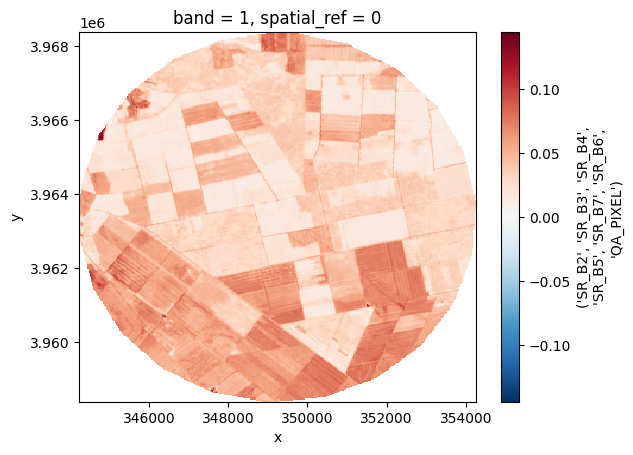

In [110]:
import rioxarray as rxr
data = rxr.open_rasterio('./Data/RS/US-NC2/2015-02-15_L8.tif')
data.sel(band=1).plot()

In [111]:
data.to_numpy().shape

(7, 333, 334)

In [90]:
data.sel(x=slice(244470.0-900, 244470.0), y=slice(4719270.0, 4719270.0-900))

<xarray.DataArray (band: 7, y: 31, x: 31)> Size: 54kB
[6727 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 248B 2.436e+05 2.436e+05 ... 2.444e+05 2.445e+05
  * y            (y) float64 248B 4.719e+06 4.719e+06 ... 4.718e+06 4.718e+06
    spatial_ref  int64 8B 0
Attributes: (12/106)
    ALGORITHM_SOURCE_SURFACE_REFLECTANCE:     LaSRC_1.5.0
    ALGORITHM_SOURCE_SURFACE_TEMPERATURE:     st_1.3.0
    CLOUD_COVER:                              2.49
    CLOUD_COVER_LAND:                         1.15
    COLLECTION_CATEGORY:                      T1
    COLLECTION_NUMBER:                        2
    ...                                       ...
    scale:                                    2.75e-05
    wavelength:                               0.452-0.512 &mu;m
    _FillValue:                               -inf
    scale_factor:                             1.0
    add_offset:                               0.0
    long_name:                                ('SR_B2', 'SR_B3', 'SR_B4', 'SR...

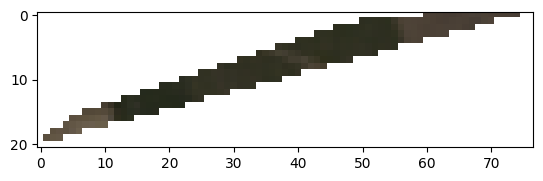

In [107]:
plt.imshow(image.swapaxes(0,2)**0.5)

In [106]:
image = np.array([data.sel(band=3).values, data.sel(band=2).values, data.sel(band=1).values])

normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    
corrected_image = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image))
corrected_image = (corrected_image * 255).astype(np.uint8)

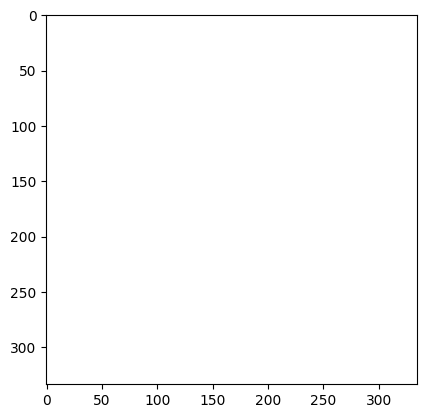

In [72]:
plt.imshow(normalized_image)